In [1]:
import pandas as pd
import os
import requests
import json
from matplotlib.patches import Patch
import streamlit as st

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [3]:
from preprocessing_utils import preprocess_NVD_data

In [4]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

Download the EPSS data from https://www.first.org/epss/data_stats into `data` folder

### <font color='blue'><b><i>TODO</i></b></font>:
- in the following cell, replace `epss_scores-2025-09-30.csv.gz` with the correct updated file (`epss_scores-2025-10-01.csv.gz`)

In [5]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-01.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below


,cve,epss,percentile
0,CVE-1999-0001,0.01141,0.77780
1,CVE-1999-0002,0.10742,0.93087
2,CVE-1999-0003,0.90362,0.99589
3,CVE-1999-0004,0.03215,0.86596
4,CVE-1999-0005,0.25334,0.96035
...,...,...,...
296328,CVE-2025-9994,0.00060,0.19138
296329,CVE-2025-9996,0.00179,0.40027
296330,CVE-2025-9997,0.00182,0.40386
296331,CVE-2025-9998,0.00023,0.04753


# NVD data

In [6]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1 

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


In [7]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus']!='Reserved') & (df['cve.vulnStatus']!='Reject')]

# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")

In [8]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)
    
# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_09.csv"))

# Exploratory Data Analysis

- display some examples (e.g., the first two CVE records)

In [9]:
df.head(10).T
# T for transpose

,0,1,2,3,4,5,6,7,8,9
cve.id,CVE-2025-9751,CVE-2025-9752,CVE-2025-9753,CVE-2025-9754,CVE-2025-9755,CVE-2025-9756,CVE-2025-9567,CVE-2025-9568,CVE-2025-9569,CVE-2025-9757
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,twcert@cert.org.tw,twcert@cert.org.tw,twcert@cert.org.tw,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000,2025-09-01 01:15:47.060000,2025-09-01 02:15:45.223000,2025-09-01 02:15:45.493000,2025-09-01 02:15:45.713000,2025-09-01 03:15:32.337000,2025-09-01 03:15:32.570000,2025-09-01 03:15:32.767000,2025-09-01 03:15:32.967000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000,2025-09-04 18:46:50.757000,2025-09-04 18:46:58.453000,2025-09-05 19:54:52.480000,2025-09-08 14:02:39.200000,2025-09-25 14:18:08.317000,2025-09-25 14:18:31.453000,2025-09-25 14:18:03.243000,2025-09-08 13:54:13.633000
cve.vulnStatus,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...,[{'url': 'https://github.com/Yashh-G/zero-day-...,[{'url': 'https://github.com/Yashh-G/zero-day-...,[{'url': 'https://gist.github.com/0xSebin/147e...,[{'url': 'https://github.com/CSentinel/CVE/iss...,[{'url': 'https://www.twcert.org.tw/en/cp-139-...,[{'url': 'https://www.twcert.org.tw/en/cp-139-...,[{'url': 'https://www.twcert.org.tw/en/cp-139-...,[{'url': 'https://github.com/lrjbsyh/CVE_Hunte...
cve.cisaExploitAdd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cve.cisaActionDue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cve.cisaRequiredAction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- show a bar plot with the daily volume of published CVEs

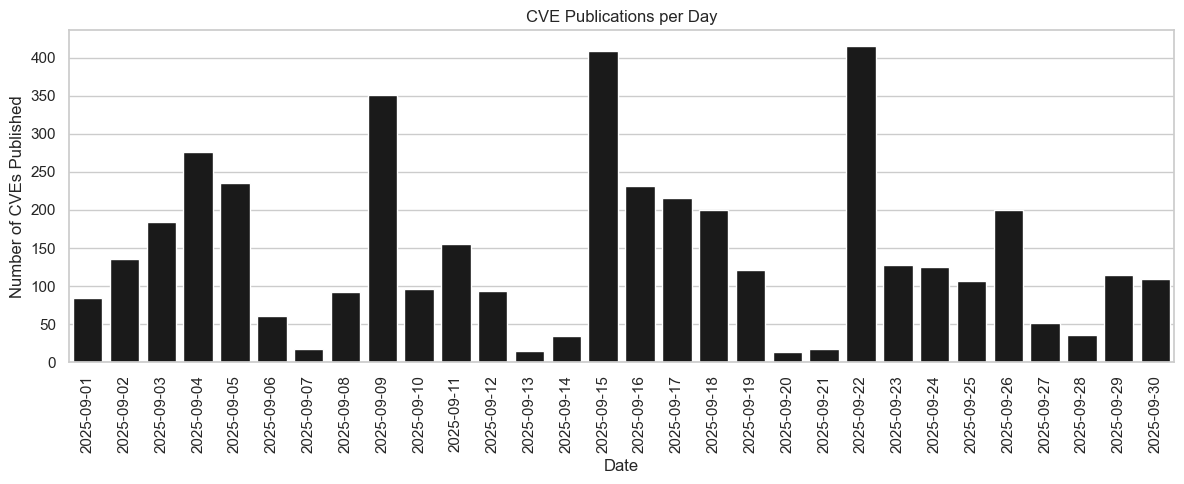

In [10]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=published_counts.index, y=published_counts.values, color="k" )
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cve.id                      4325 non-null   object        
 1   cve.sourceIdentifier        4325 non-null   object        
 2   cve.published               4325 non-null   datetime64[ns]
 3   cve.lastModified            4325 non-null   datetime64[ns]
 4   cve.vulnStatus              4325 non-null   object        
 5   cve.references              4325 non-null   object        
 6   cve.cisaExploitAdd          9 non-null      object        
 7   cve.cisaActionDue           9 non-null      object        
 8   cve.cisaRequiredAction      9 non-null      object        
 9   cve.cisaVulnerabilityName   9 non-null      object        
 10  description                 4325 non-null   object        
 11  vulnerable_cpes             4325 non-null   object      

- print the description of the last ten published vulnerabilities

In [12]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### <font color='blue'><b><i>TODO</i></b>: produce plots or tables to address the folowing points</font>
- what is the percentage of CVEs which received a CVSS score?
- report descriptive statistics of CVSS the CVSS base score and/or show its distribution
- report descriptive statistics of EPSS and/or show its distribution
- produce a scatter plot showing CVSS vs EPSS
- <b>be creative</b>!
    - How many vulnerabilities are published on CISA KEV? 
    - What are the the 20 most frequent vendors? (vendor name can be extracted from the `vulnerable_cpes` field).
    - What are the 20 most frequent CWEs?
    - Anaything else you see fit!

<font color='blue'>Use text cells to discuss the outcome after each point</font>

## Percentage of CVEs with CVSS Score

Let's analyze what percentage of the CVEs in the dataset have been assigned a CVSS score, which will help us understand the coverage of vulnerability severity assessment.

In [13]:
# Calculate the percentage of CVEs with CVSS scores
total_cves = len(df)
cves_with_cvss = df['cvss_baseScore'].notna().sum()
percentage = (cves_with_cvss / total_cves) * 100

print(f"Total number of CVEs: {total_cves}")
print(f"CVEs with CVSS scores: {cves_with_cvss}")
print(f"Percentage of CVEs with CVSS scores: {percentage:.2f}%")

Total number of CVEs: 4325
CVEs with CVSS scores: 3344
Percentage of CVEs with CVSS scores: 77.32%


## CVSS Base Score Analysis

Let's examine the distribution and descriptive statistics of the CVSS base scores to understand the severity levels of the vulnerabilities in our dataset.

CVSS Base Score Statistics:
count    3344.000000
mean        6.906041
std         1.804292
min         2.200000
25%         5.400000
50%         6.500000
75%         8.200000
max        10.000000
Name: cvss_baseScore, dtype: float64


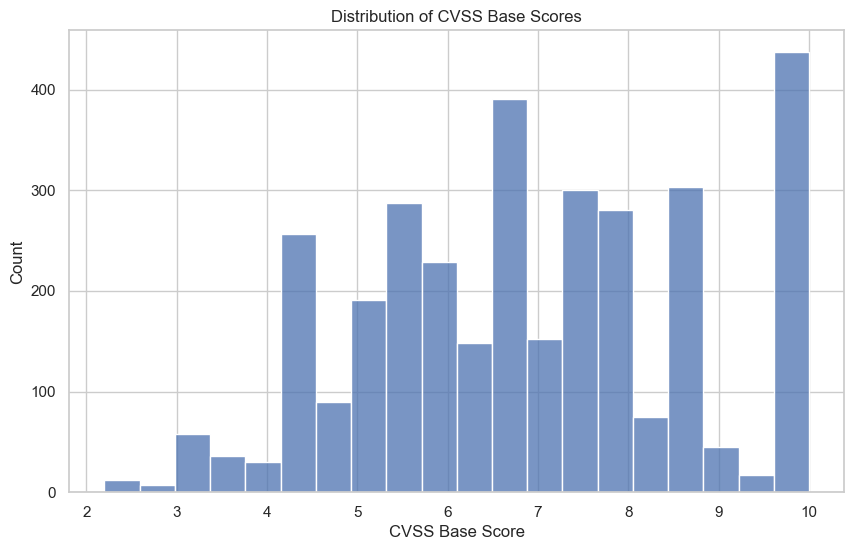

In [14]:
# Analyze CVSS base score distribution
cvss_stats = df['cvss_baseScore'].describe()
print("CVSS Base Score Statistics:")
print(cvss_stats)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='cvss_baseScore', bins=20)
plt.title('Distribution of CVSS Base Scores')
plt.xlabel('CVSS Base Score')
plt.ylabel('Count')
plt.show()

C:\Users\lucas\AppData\Local\Temp\ipykernel_18436\3819912328.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['cvss_category'].isin(category_percentages.index)],


C:\Users\lucas\AppData\Local\Temp\ipykernel_18436\3819912328.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['cvss_category'].isin(category_percentages.index)],


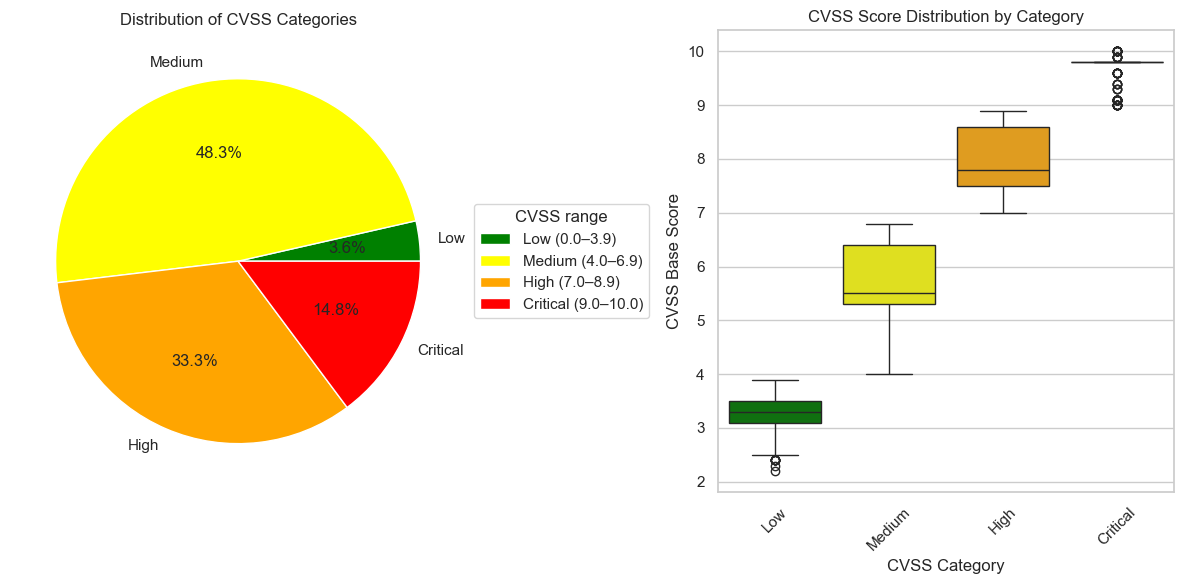


Summary Statistics by CVSS Category:
                count      mean       std  min  25%  50%  75%   max
cvss_category                                                      
Low             119.0  3.249580  0.388800  2.2  3.1  3.3  3.5   3.9
Medium         1616.0  5.612376  0.805028  4.0  5.3  5.5  6.4   6.8
High           1114.0  7.915260  0.598576  7.0  7.5  7.8  8.6   8.9
Critical        495.0  9.737172  0.211492  9.0  9.8  9.8  9.8  10.0


In [23]:
# Define Cvss categories
def cvss_categorization(score):
    if pd.isna(score):
        return 'Unknown/NA'
    elif score < 4.0:
        return 'Low'
    elif 4.0 <= score < 7.0:
        return 'Medium'
    elif 7.0 <= score < 9.0:
        return 'High'
    else:
        return 'Critical'

df['cvss_category'] = df['cvss_baseScore'].apply(cvss_categorization)

# Calculate percentages of each CVSS category
total_vulns = len(df[df['cvss_baseScore'].notna()])
category_percentages = (df['cvss_category'].value_counts() / total_vulns * 100).round(2)

# Exclude the 'Unknown/NA' label and order categories by severity
desired_order = ['Low', 'Medium', 'High', 'Critical']
# Keep only the desired categories in that order and drop missing ones
category_percentages = category_percentages.reindex(desired_order).dropna()

# Create a pie chart
plt.figure(figsize=(12, 6))

# Subplot 1: Pie chart
plt.subplot(1, 2, 1)
palette = {'Low':'green', 'Medium':'yellow', 'High':'orange', 'Critical':'red'}
colors = [palette[c] for c in category_percentages.index]
plt.pie(category_percentages, labels=category_percentages.index, colors=colors, autopct='%1.1f%%')
# Add a legend describing the numeric CVSS ranges for each category

range_labels = {'Low':'0.0–3.9', 'Medium':'4.0–6.9', 'High':'7.0–8.9', 'Critical':'9.0–10.0'}
handles = [Patch(facecolor=palette[c], label=f"{c} ({range_labels[c]})") for c in category_percentages.index]
plt.legend(handles=handles, title='CVSS range', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distribution of CVSS Categories')

# Subplot 2: Box plot by category
plt.subplot(1, 2, 2)
#sns.boxplot(data=df, x='cvss_category', y='cvss_baseScore', order=desired_order, 
          # palette=colors)
# Restrict boxplot to same categories and use same order/colors
sns.boxplot(data=df[df['cvss_category'].isin(category_percentages.index)], 
            x='cvss_category', y='cvss_baseScore', 
            order=category_percentages.index, palette=colors)
plt.xticks(rotation=45)
plt.title('CVSS Score Distribution by Category')
plt.xlabel('CVSS Category')
plt.ylabel('CVSS Base Score')

plt.tight_layout()
plt.show()

# Print summary statistics by category (exclude Unknown/NA and keep desired order)
summary = df[df['cvss_category'].isin(desired_order)].groupby('cvss_category')['cvss_baseScore'].describe().reindex(desired_order)
print("\nSummary Statistics by CVSS Category:")
print(summary)

## EPSS Distribution Analysis

Let's analyze the distribution of EPSS scores to understand the likelihood of vulnerabilities being exploited in the dataset.

EPSS Score Statistics:
count    4325.000000
mean        0.001476
std         0.017279
min         0.000020
25%         0.000240
50%         0.000320
75%         0.000470
max         0.810640
Name: epss, dtype: float64


EPSS Score Statistics:
count    4325.000000
mean        0.001476
std         0.017279
min         0.000020
25%         0.000240
50%         0.000320
75%         0.000470
max         0.810640
Name: epss, dtype: float64


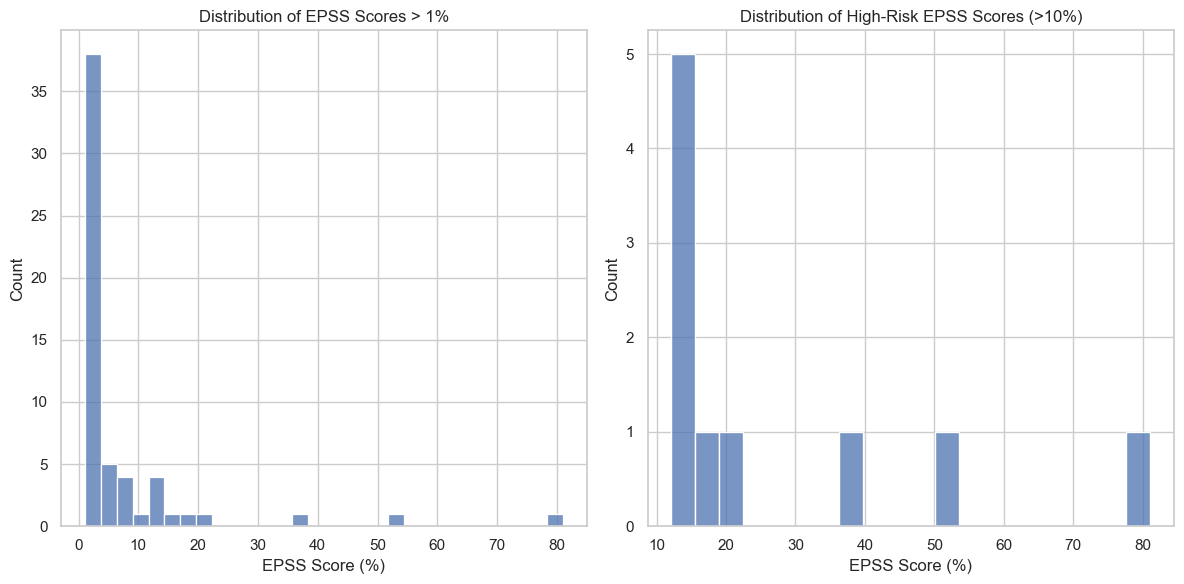

EPSS Score Statistics:
count    4325.000000
mean        0.001476
std         0.017279
min         0.000020
25%         0.000240
50%         0.000320
75%         0.000470
max         0.810640
Name: epss, dtype: float64


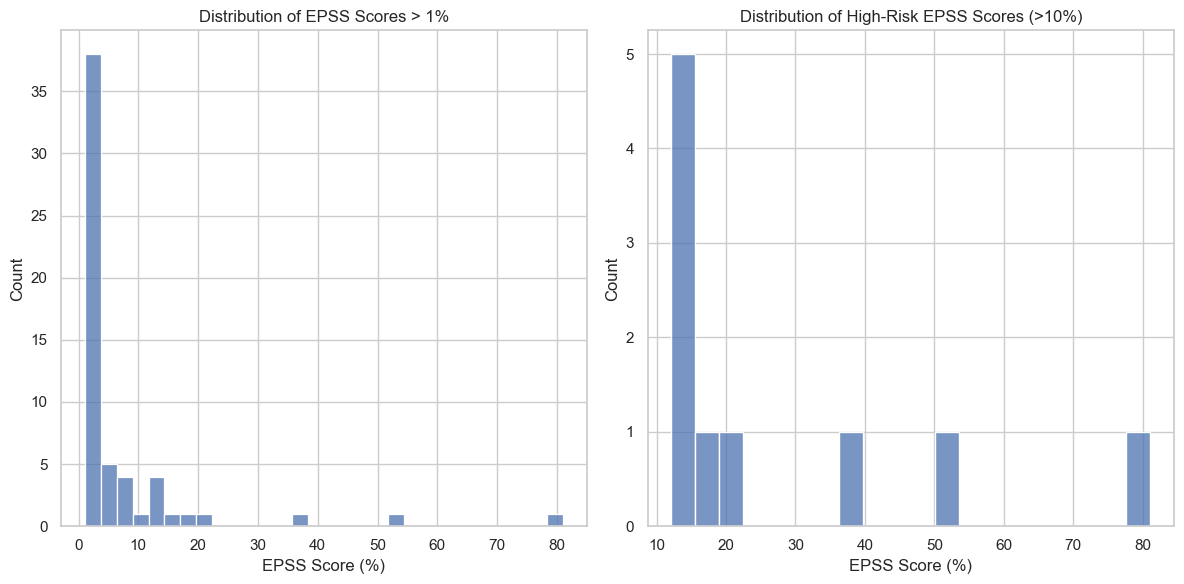


Risk Distribution Summary:
Total Vulnerabilities: 4325
High Risk (EPSS > 10%): 10 (0.23%)
Medium Risk (1% < EPSS ≤ 10%): 48 (1.11%)
Low Risk (EPSS ≤ 1%): 4267 (98.66%)


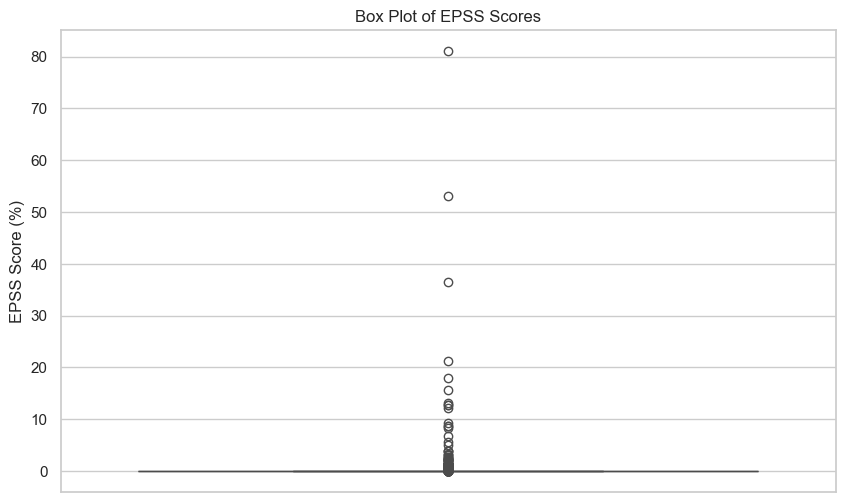

In [28]:
# Analyze EPSS distribution
epss_stats = df['epss'].describe()
print("EPSS Score Statistics:")
print(epss_stats)

# Convert EPSS to percentage for better readability
df['epss_percentage'] = df['epss'] * 100

# Create more informative plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Plot for EPSS > 1%
sns.histplot(data=df[df['epss_percentage'] > 1], x='epss_percentage', bins=30)
plt.title('Distribution of EPSS Scores > 1%')
plt.xlabel('EPSS Score (%)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
# Plot focusing on high-risk vulnerabilities
sns.histplot(data=df[df['epss_percentage'] > 10], x='epss_percentage', bins=20)
plt.title('Distribution of High-Risk EPSS Scores (>10%)')
plt.xlabel('EPSS Score (%)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Add summary statistics
total_vulns = len(df)
high_risk = len(df[df['epss_percentage'] > 10])
medium_risk = len(df[(df['epss_percentage'] <= 10) & (df['epss_percentage'] > 1)])
low_risk = len(df[df['epss_percentage'] <= 1])

print("\nRisk Distribution Summary:")
print(f"Total Vulnerabilities: {total_vulns}")
print(f"High Risk (EPSS > 10%): {high_risk} ({(high_risk/total_vulns)*100:.2f}%)")
print(f"Medium Risk (1% < EPSS ≤ 10%): {medium_risk} ({(medium_risk/total_vulns)*100:.2f}%)")
print(f"Low Risk (EPSS ≤ 1%): {low_risk} ({(low_risk/total_vulns)*100:.2f}%)")

# Show box plot for better visualization of outliers
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['epss_percentage'])
plt.title('Box Plot of EPSS Scores')
plt.ylabel('EPSS Score (%)')
plt.show()

## CVSS vs EPSS Correlation

Let's create a scatter plot to visualize the relationship between CVSS base scores and EPSS scores to understand if there's any correlation between vulnerability severity and exploitation probability.

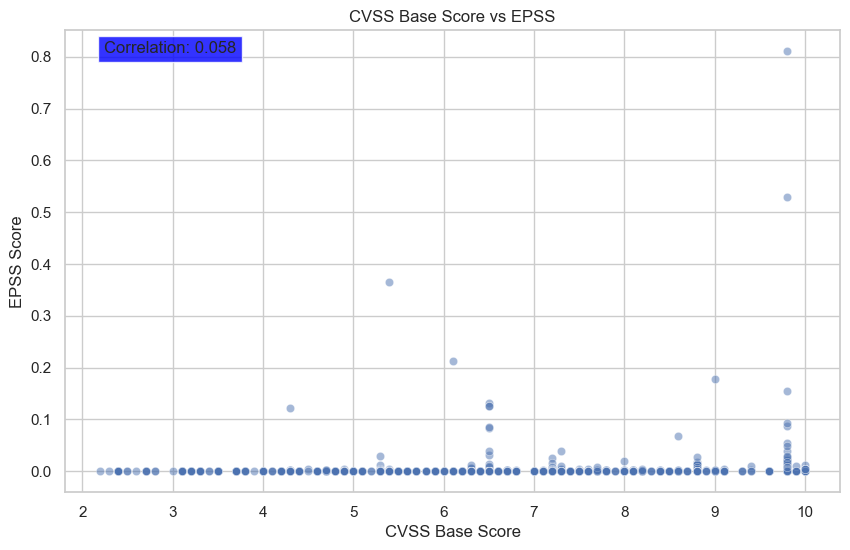

In [30]:
filtered_data = df.dropna(subset=['cvss_baseScore', 'epss'])

# Create scatter plot of CVSS vs EPSS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, 
                x='cvss_baseScore',
                y='epss',
                alpha=0.5,
                color='red')
plt.title('CVSS Base Score vs EPSS')
plt.xlabel('CVSS Base Score')
plt.ylabel('EPSS Score')

# Calculate correlation
correlation = filtered_data['cvss_baseScore'].corr(filtered_data['epss'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Additional analysis


## TAKE A LOOK AT:
        CVE REFERENCES.....NUM_REFERENCES......CWE_LIST.......PERCENTILE!!!!!!!

# CVE selection


### <font color='blue'><b><i>TODO</i></b>
- Filter the CVEs with low EPSS (<1%)
- Select candidate CVEs
    - From the resulting subset, select 10 CVEs that you think will reach high EPSS by the end of the course.
    - Clearly describe the criteria you used for selection (e.g., high CVSS, popular software, CWE, popular vendor, number of references, keyword in description, manual inspection, random sampling, security blogs).
- Share the selected CVE ids with the instructor (by two weeks). Use the code cell below to produce the csv file to submit.
- Track the EPSS of your CVEs over time


## EPSS Filtering
    
    First of all I am filtering EPSS with low score, keeping only the ones with a score lower than 0.1 (1%)

In [35]:
# Filtering out low EPSS scores - less than 0.1 (1%)
low_epss_df = df.loc[df['epss'] < 0.1]
filtered_df = low_epss_df["epss"]

print(filtered_df)

0       0.00030
1       0.00242
2       0.00026
3       0.00028
4       0.00028
         ...   
4320    0.00018
4321    0.00027
4322    0.00150
4323    0.00028
4324    0.00017
Name: epss, Length: 4315, dtype: float64


In [36]:
nickname = 'TheExploitables' # TODO: put your nickname here


# TODO: put your selected IDs here
selected = ['CVE-YYYY-XXXXX0',
            'CVE-YYYY-XXXXX1',
            'CVE-YYYY-XXXXX2',
            'CVE-YYYY-XXXXX3',
            'CVE-YYYY-XXXXX4',
            'CVE-YYYY-XXXXX5',
            'CVE-YYYY-XXXXX6',
            'CVE-YYYY-XXXXX7',
            'CVE-YYYY-XXXXX8',
            'CVE-YYYY-XXXXX9',
           ]            

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv'))            